# Unity ML Agents
## Environment Basics
This notebook contains a walkthrough of the basic functions of the Python API for Unity ML Agents. For instructions on building a Unity environment, see [here](https://github.com/Unity-Technologies/ml-agents/wiki/Getting-Started-with-Balance-Ball).

### 1. Load dependencies

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import cv2
import random
import datetime
import os
import time

from unityagents import UnityEnvironment

%matplotlib inline

### 2. Set environment parameters

Be sure to set `env_name` to the name of the Unity environment file you want to launch.

In [2]:
env_name = "./ML_Agent_VehicleSimulator/ML_Agent_VehicleSimulator_static" # Name of the Unity environment binary to launch
train_mode = True # Whether to run the environment in training or inference mode

### 3. Start the environment
`UnityEnvironment` launches and begins communication with the environment when instantiated.

Environments contain _brains_ which are responsible for deciding the actions of their associated _agents_. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
env = UnityEnvironment(file_name=env_name)

# Examine environment parameters
print(str(env))

# Set the default brain to work with
default_brain = env.brain_names[0]
brain = env.brains[default_brain]

INFO:unityagents:
'Academy' started successfully!


Unity Academy name: Academy
        Number of brains: 1
        Reset Parameters :
		
Unity brain name: Brain
        Number of observations (per agent): 1
        State space type: discrete
        State space size (per agent): 1
        Action space type: discrete
        Action space size (per agent): 3
        Memory space size (per agent): 0
        Action descriptions: a, d, s


### 4. Examine the observation and state spaces
We can reset the environment to be provided with an initial set of observations and states for all the agents within the environment. In ML-Agents, _states_ refer to a vector of variables corresponding to relevant aspects of the environment for an agent. Likewise, _observations_ refer to a set of relevant pixel-wise visuals for an agent.

Agent state looks like: 
[ 0.]
Agent observations look like:


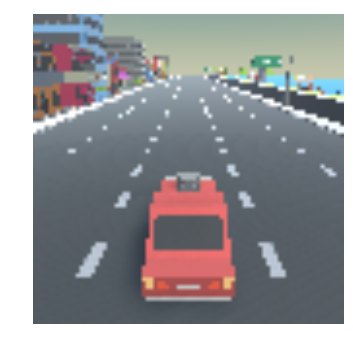

In [4]:
# Reset the environment
env_info = env.reset(train_mode=train_mode)[default_brain]

# Examine the state space for the default brain
print("Agent state looks like: \n{}".format(env_info.states[0]))

# Examine the observation space for the default brain
Num_obs = len(env_info.observations)

print("Agent observations look like:")
if Num_obs > 1:
    f, axarr = plt.subplots(1, Num_obs, figsize=(20,10))
    for i, observation in enumerate(env_info.observations):
        if observation.shape[3] == 3:
            axarr[i].imshow(observation[0,:,:,:])
            axarr[i].axis('off')
        else:
            axarr[i].imshow(observation[0,:,:,0])
            axarr[i].axis('off')
else:
    f, axarr = plt.subplots(1, Num_obs)
    for i, observation in enumerate(env_info.observations):
        if observation.shape[3] == 3:
            axarr.imshow(observation[0,:,:,:])
            axarr.axis('off')
        else:
            axarr.imshow(observation[0,:,:,0])
            axarr.axis('off')

### 5. Parameters

In [5]:
import random

Gamma = 0.99
Learning_rate = 0.00025

algorithm = 'NoisyDQN'
Num_action = brain.action_space_size

Num_replay_memory = 100000
Num_start_training = 100000
Num_training = 1000000
Num_update = 10000
Num_batch = 32
Num_test = 100000
Num_skipFrame = 4
Num_stackFrame = 4
Num_colorChannel = 1

Num_plot_episode = 50
Num_step_save = 50000

GPU_fraction = 0.3

img_size = 80

first_conv   = [8,8,Num_colorChannel * Num_stackFrame * Num_obs,32]
second_conv  = [4,4,32,64]
third_conv   = [3,3,64,64]
first_dense  = [10*10*64, 512]
second_dense = [512, Num_action]

train_mode = True
env_info = env.reset(train_mode=train_mode)[default_brain]
state = env_info.states[0]
state = str(state)

score_list = []
check_show_progress = 0


### Functions for Networks

In [6]:
# Initialize weights and bias
def weight_variable(shape):
    return tf.Variable(xavier_initializer(shape))

def bias_variable(shape):
	return tf.Variable(xavier_initializer(shape))

def mu_variable(shape):
    return tf.Variable(tf.random_uniform(shape, minval = -tf.sqrt(3/shape[0]), maxval = tf.sqrt(3/shape[0])))

def sigma_variable(shape):
	return tf.Variable(tf.constant(0.017, shape = shape))

# Xavier Weights initializer
def xavier_initializer(shape):
	dim_sum = np.sum(shape)
	if len(shape) == 1:
		dim_sum += 1
	bound = np.sqrt(2.0 / dim_sum)
	return tf.random_uniform(shape, minval=-bound, maxval=bound)

# Convolution and pooling
def conv2d(x,w, stride):
	return tf.nn.conv2d(x,w,strides=[1, stride, stride, 1], padding='SAME')

def max_pool_2x2(x):
	return tf.nn.max_pool(x, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')

def assign_network_to_target():
	# Get trainable variables
	trainable_variables = tf.trainable_variables()
	# network lstm variables
	trainable_variables_network = [var for var in trainable_variables if var.name.startswith('network')]

	# target lstm variables
	trainable_variables_target = [var for var in trainable_variables if var.name.startswith('target')]

	for i in range(len(trainable_variables_network)):
		sess.run(tf.assign(trainable_variables_target[i], trainable_variables_network[i]))

########################################### Noisy Network ###########################################
def noisy_dense(input_, input_shape, mu_w, sig_w, mu_b, sig_b, is_train_process):
	eps_w = tf.cond(is_train_process, lambda: tf.random_normal(input_shape), lambda: tf.zeros(input_shape))
	eps_b = tf.cond(is_train_process, lambda: tf.random_normal([input_shape[1]]), lambda: tf.zeros([input_shape[1]]))

	w_fc = tf.add(mu_w, tf.multiply(sig_w, eps_w))
	b_fc = tf.add(mu_b, tf.multiply(sig_b, eps_b))

	return tf.matmul(input_, w_fc) + b_fc
#####################################################################################################

# Code for tensorboard
def setup_summary():
    episode_score   = tf.Variable(0.)

    tf.summary.scalar('Average_Score/' + str(Num_plot_episode) + 'episodes', episode_score)

    summary_vars = [episode_score]
    summary_placeholders = [tf.placeholder(tf.float32) for _ in range(len(summary_vars))]
    update_ops = [summary_vars[i].assign(summary_placeholders[i]) for i in range(len(summary_vars))]
    summary_op = tf.summary.merge_all()
    return summary_placeholders, update_ops, summary_op

### Network

In [7]:
# Input
x_image = tf.placeholder(tf.float32, shape = [None, img_size, img_size, Num_colorChannel * Num_stackFrame * Num_obs])
x_normalize = (x_image - (255.0/2)) / (255.0/2)

########################################### Noisy Network ###########################################
train_process = tf.placeholder(tf.bool)
#####################################################################################################

with tf.variable_scope('network'):
    # Convolution variables
    w_conv1 = weight_variable(first_conv)
    b_conv1 = bias_variable([first_conv[3]])

    w_conv2 = weight_variable(second_conv)
    b_conv2 = bias_variable([second_conv[3]])

    w_conv3 = weight_variable(third_conv)
    b_conv3 = bias_variable([third_conv[3]])

########################################### Noisy Network ###########################################
    # Densely connect layer variables (Noisy)
    mu_w1  = mu_variable(first_dense)
    sig_w1 = sigma_variable(first_dense)
    mu_b1  = mu_variable([first_dense[1]])
    sig_b1 = sigma_variable([first_dense[1]])

    mu_w2  = mu_variable(second_dense)
    sig_w2 = sigma_variable(second_dense)
    mu_b2  = mu_variable([second_dense[1]])
    sig_b2 = sigma_variable([second_dense[1]])
#####################################################################################################

# Network
h_conv1 = tf.nn.relu(conv2d(x_normalize, w_conv1, 4) + b_conv1)
h_conv2 = tf.nn.relu(conv2d(h_conv1, w_conv2, 2) + b_conv2)
h_conv3 = tf.nn.relu(conv2d(h_conv2, w_conv3, 1) + b_conv3)

h_pool3_flat = tf.reshape(h_conv3, [-1, first_dense[0]])

########################################### Noisy Network ###########################################
h_fc1 = tf.nn.relu(noisy_dense(h_pool3_flat, first_dense, mu_w1, sig_w1, mu_b1, sig_b1, train_process))
output = noisy_dense(h_fc1, second_dense, mu_w2, sig_w2, mu_b2, sig_b2, train_process)
#####################################################################################################

with tf.variable_scope('target'):
    # Convolution variables target
    w_conv1_target = weight_variable(first_conv)
    b_conv1_target = bias_variable([first_conv[3]])

    w_conv2_target = weight_variable(second_conv)
    b_conv2_target = bias_variable([second_conv[3]])

    w_conv3_target = weight_variable(third_conv)
    b_conv3_target = bias_variable([third_conv[3]])

########################################### Noisy Network ###########################################
    # Densely connect layer variables target (Noisy)
    mu_w1_target  = mu_variable(first_dense)
    sig_w1_target = sigma_variable(first_dense)
    mu_b1_target  = mu_variable([first_dense[1]])
    sig_b1_target = sigma_variable([first_dense[1]])

    mu_w2_target  = mu_variable(second_dense)
    sig_w2_target = sigma_variable(second_dense)
    mu_b2_target  = mu_variable([second_dense[1]])
    sig_b2_target = sigma_variable([second_dense[1]])
#####################################################################################################

# Target Network
h_conv1_target = tf.nn.relu(conv2d(x_normalize, w_conv1_target, 4) + b_conv1_target)
h_conv2_target = tf.nn.relu(conv2d(h_conv1_target, w_conv2_target, 2) + b_conv2_target)
h_conv3_target = tf.nn.relu(conv2d(h_conv2_target, w_conv3_target, 1) + b_conv3_target)

h_pool3_flat_target = tf.reshape(h_conv3_target, [-1, first_dense[0]])

########################################### Noisy Network ###########################################
h_fc1_target = tf.nn.relu(noisy_dense(h_pool3_flat_target, first_dense, mu_w1_target, sig_w1_target, mu_b1_target, sig_b1_target, train_process))
output_target = noisy_dense(h_fc1_target, second_dense, mu_w2_target, sig_w2_target, mu_b2_target, sig_b2_target, train_process)
#####################################################################################################

### Loss

In [8]:
# Loss function and Train
action_target = tf.placeholder(tf.float32, shape = [None, Num_action])
y_prediction = tf.placeholder(tf.float32, shape = [None])

y_target = tf.reduce_sum(tf.multiply(output, action_target), reduction_indices = 1)
Loss = tf.reduce_mean(tf.square(y_prediction - y_target))
train_step = tf.train.AdamOptimizer(learning_rate = Learning_rate, epsilon = 1e-02).minimize(Loss)

### Config

In [9]:
## Initialize variables
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = GPU_fraction

sess = tf.InteractiveSession(config=config)

# date - hour - minute of training time
date_time = str(datetime.date.today()) + '_' + str(datetime.datetime.now().hour) + '_' + str(datetime.datetime.now().minute)

# Make folder for save data
os.makedirs('saved_networks/' + date_time + '_' + algorithm)

# Summary for tensorboard
summary_placeholders, update_ops, summary_op = setup_summary()
summary_writer = tf.summary.FileWriter('saved_networks/' + date_time + '_' + algorithm, sess.graph)

init = tf.global_variables_initializer()
sess.run(init)

# Load the file if the saved file exists
saver = tf.train.Saver()

# check_save = 1
check_save = input('Is there any saved data?(1=y/2=n): ')

if check_save == 1:
    # Restore variables from disk.
    saver.restore(sess, 'saved_networks/' + date_time + '_' + algorithm + "/model.ckpt")
    print("Model restored.")


Is there any saved data?(1=y/2=n): 2


### Functions for Training

In [10]:
# Initialize_input
def input_initialization(env_info):
    observation_stack_obs = np.zeros([img_size, img_size, Num_colorChannel * Num_obs])
    
    for i in range(Num_obs):
        observation = 255 * env_info.observations[i]
        observation = np.uint8(observation)
        observation = np.reshape(observation, (80, 80, 3))
        observation = cv2.resize(observation, (img_size, img_size))

        if Num_colorChannel == 1:
            observation = cv2.cvtColor(observation, cv2.COLOR_RGB2GRAY)
            observation = np.reshape(observation, (img_size, img_size))

        if Num_colorChannel == 3:
            observation_stack_obs[:,:, Num_colorChannel * i: Num_colorChannel * (i+1)] = observation
        else:
            observation_stack_obs[:,:, i] = observation

    observation_set = []

    for i in range(Num_skipFrame * Num_stackFrame):
        observation_set.append(observation_stack_obs)
    
    # Stack the frame according to the number of skipping and stacking frames using observation set
    observation_stack = np.zeros((img_size, img_size, Num_colorChannel * Num_stackFrame * Num_obs))
    for stack_frame in range(Num_stackFrame):
        observation_stack[:,:,Num_obs * stack_frame: Num_obs * (stack_frame+1)] = observation_set[-1 - (Num_skipFrame * stack_frame)]

    observation_stack = np.uint8(observation_stack)

    return observation_stack, observation_set

def resize_input(env_info, observation_set):
    # Stack observation according to the number of observations
    observation_stack_obs = np.zeros([img_size, img_size, Num_colorChannel * Num_obs])

    for i in range(Num_obs):
        observation = 255 * env_info.observations[i]
        observation = np.uint8(observation)
        observation = np.reshape(observation, (80, 80, 3))
        observation = cv2.resize(observation, (img_size, img_size))
        
        if Num_colorChannel == 1:
            observation = cv2.cvtColor(observation, cv2.COLOR_RGB2GRAY)
            observation = np.reshape(observation, (img_size, img_size))

        if Num_colorChannel == 3:
            observation_stack_obs[:,:, Num_colorChannel * i: Num_colorChannel * (i+1)] = observation
        else:
            observation_stack_obs[:,:,i] = observation
    
    # Add observations to the observation_set
    observation_set.append(observation_stack_obs)
    
    # Stack the frame according to the number of skipping and stacking frames using observation set
    observation_stack = np.zeros((img_size, img_size, Num_colorChannel * Num_stackFrame * Num_obs))
    for stack_frame in range(Num_stackFrame):
        observation_stack[:,:,Num_obs * stack_frame: Num_obs * (stack_frame+1)] = observation_set[-1 - (Num_skipFrame * stack_frame)]

    del observation_set[0]

    observation_stack = np.uint8(observation_stack)
    
    return observation_stack, observation_set

# Get progress according to the 
def get_progress(step):
    if step <= Num_start_training:
        # Observation
        progress = 'Observing'
        train_mode = True

    elif step <= Num_start_training + Num_training:
        # Training
        progress = 'Training'
        train_mode = True
        
    elif step < Num_start_training + Num_training + Num_test:
        # Testing
        progress = 'Testing'
        train_mode = False

    else:
        # Finished
        progress = 'Finished'
        train_mode = False
        
    return progress, train_mode 

# Select action according to the progress of training
def select_action(progress, sess, observation_stack, train_mode):
    if progress == "Observing":
        Q_value = 0
        action = np.zeros([Num_action])
        action[random.randint(0, Num_action - 1)] = 1.0
    else:
        Q_value = output.eval(feed_dict={x_image: [observation_stack], train_process: train_mode})
        action = np.zeros([Num_action])
        action[np.argmax(Q_value)] = 1
    return action, Q_value

def train(Replay_memory, sess, step):
    # Select minibatch
    minibatch =  random.sample(Replay_memory, Num_batch)

    # Save the each batch data
    observation_batch      = [batch[0] for batch in minibatch]
    action_batch           = [batch[1] for batch in minibatch]
    reward_batch           = [batch[2] for batch in minibatch]
    observation_next_batch = [batch[3] for batch in minibatch]
    terminal_batch 	       = [batch[4] for batch in minibatch]

    # Update target network according to the Num_update value
    if step % Num_update == 0:
        assign_network_to_target()

    ########################################### Noisy Network ###########################################
    # Get y_prediction
    y_batch = []
    Q_batch = output_target.eval(feed_dict = {x_image: observation_next_batch, train_process: True})
    for i in range(len(minibatch)):
        if terminal_batch[i] == True:
            y_batch.append(reward_batch[i])
        else:
            y_batch.append(reward_batch[i] + Gamma * np.max(Q_batch[i]))

    _, loss = sess.run([train_step, Loss], feed_dict = {action_target: action_batch, y_prediction: y_batch, x_image: observation_batch, train_process: True})
    #####################################################################################################

# Experience Replay 
def Experience_Replay(progress, Replay_memory, observation_stack, action, reward, next_observation_stack, terminal):
    if progress != 'Testing':
        # If length of replay memeory is more than the setting value then remove the first one
        if len(Replay_memory) > Num_replay_memory:
            del Replay_memory[0]

        # Save experience to the Replay memory
        Replay_memory.append([observation_stack, action, reward, next_observation_stack, terminal])
    else:
        # Empty the replay memory if testing
        Replay_memory = []
    
    return Replay_memory

### Initialize Variables

In [11]:
# Initial parameters
Replay_memory = []
step = 1
score = 0
score_board = 0

episode = 0
step_per_episode = 0

train_mode = True
env_info = env.reset(train_mode=train_mode)[default_brain]

observation_stack, observation_set = input_initialization(env_info)

### Training

In [12]:
check_plot = 0

# Training & Testing
while True:
    
    # Get Progress, train mode
    progress, train_mode  = get_progress(step)
    
    # Select Actions 
    action, Q_value = select_action(progress, sess, observation_stack, train_mode)
    action_in = [np.argmax(action)]

    # Get information for update
    env_info = env.step(action_in)[default_brain]

    next_observation_stack, observation_set = resize_input(env_info, observation_set) 
    reward = env_info.rewards[0]
    terminal = env_info.local_done[0]
    
    if progress == 'Training':
        # Train!! 
        train(Replay_memory, sess, step)

        # Save the variables to disk.
        if step == Num_start_training + Num_training:
            save_path = saver.save(sess, 'saved_networks/' + date_time + '_' + algorithm + "/model.ckpt")
            print("Model saved in file: %s" % save_path)
    
    # If progress is finished -> close! 
    if progress == 'Finished':
        print('Finished!!')
        env.close()
        break

    # Experience Replay
    Replay_memory = Experience_Replay(progress, Replay_memory, observation_stack, action, reward, next_observation_stack, terminal)
    
    # Update information
    step += 1
    score += reward
    step_per_episode += 1
    observation_stack = next_observation_stack
    
    # Update tensorboard
    if progress != 'Observing':
        if episode % Num_plot_episode == 0 and check_plot == 1 and episode != 0:
            tensorboard_info = [score_board / Num_plot_episode]
            for i in range(len(tensorboard_info)):
                sess.run(update_ops[i], feed_dict = {summary_placeholders[i]: float(tensorboard_info[i])})
            summary_str = sess.run(summary_op)
            summary_writer.add_summary(summary_str, step)
            score_board = 0
            check_plot = 0
            
    # If terminal is True
    if terminal == True:
        # Print informations
        print('step: ' + str(step) + ' / '  + 'episode: ' + str(episode) + ' / ' + 'progress: ' + progress  + ' / ' + 'score: ' + str(score))

        check_plot = 1

        if progress != 'Observing':
            episode += 1
            
            score_board += score
            
        score = 0
        step_per_episode = 0

        # Initialize game state
        env_info = env.reset(train_mode=train_mode)[default_brain]
        observation_stack, observation_set = input_initialization(env_info)

        



step: 150 / episode: 0 / progress: Observing / score: -1.2914285520700006
step: 286 / episode: 0 / progress: Observing / score: 0.5592857397649995
step: 464 / episode: 0 / progress: Observing / score: 0.7707143095199855
step: 586 / episode: 0 / progress: Observing / score: -1.2949999806049997
step: 767 / episode: 0 / progress: Observing / score: -1.1264285461150005
step: 978 / episode: 0 / progress: Observing / score: -0.7028571189250008
step: 1304 / episode: 0 / progress: Observing / score: -0.10714281721500218
step: 1522 / episode: 0 / progress: Observing / score: -0.9935714063000012
step: 1689 / episode: 0 / progress: Observing / score: -1.102857122145
step: 1863 / episode: 0 / progress: Observing / score: -1.168571409530001
step: 2045 / episode: 0 / progress: Observing / score: -1.0999999858200002
step: 2183 / episode: 0 / progress: Observing / score: -1.5349999864150001
step: 2362 / episode: 0 / progress: Observing / score: -0.9821428366450007
step: 2593 / episode: 0 / progress: O